In [165]:
import pandas as pd 
import torch
import numpy as np
from matplotlib import pyplot as plt
#from torchmetrics import JaccardIndex
import seaborn as sbn
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import torchvision
import torchvision.transforms as transforms
import copy 

import sys 
sys.path.append('../src/')
from data_loading import load_tabular_data, preprocess_data, corrupt_label
from GenDataset import GenDataset
from DVGS import DVGS
from DVRL import DVRL
from utils import get_corruption_scores
from NN import NN
from LogisticRegression import LogisticRegression
from EmbEst import EmbEst
from NNEst import NNEst
from CNN import CNN
import similarities 
import DShap
from LOO import LOO
from sklearn.utils.class_weight import compute_class_weight
from utils import load_data, get_filtered_scores

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
x_train, y_train, x_valid, y_valid, x_test, y_test, exog_noise, endog_noise = load_data(dataset     = 'cifar10', 
                                                                                        train_num   = 10000, 
                                                                                        valid_num   = 10000, 
                                                                                        exog_noise  = 0., 
                                                                                        endog_noise = 0.2, 
                                                                                        save_dir    = './temp-data/', 
                                                                                        clean_up    = False)

print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())                                                                                        

Files already downloaded and verified
Files already downloaded and verified
train size: torch.Size([10000, 3, 32, 32]) torch.Size([10000, 1])
valid size: torch.Size([10000, 3, 32, 32]) torch.Size([10000, 1])
test size: torch.Size([10000, 3, 32, 32]) torch.Size([10000, 1])


In [149]:
x_train = x_train.view(x_train.size(0), -1)
x_valid = x_valid.view(x_valid.size(0), -1)
x_test = x_test.view(x_test.size(0), -1)

In [150]:
print('train size:', x_train.size(), y_train.size())                                                                                        
print('valid size:', x_valid.size(), y_valid.size())                                                                                        
print('test size:', x_test.size(), y_test.size())     

train size: torch.Size([10000, 3072]) torch.Size([10000, 1])
valid size: torch.Size([10000, 3072]) torch.Size([10000, 1])
test size: torch.Size([10000, 3072]) torch.Size([10000, 1])


In [169]:
model = NN(in_channels=x_train.size(1), out_channels=10, num_layers=2, hidden_channels=100, norm=True, dropout=0.5, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))

In [152]:
dvgs = DVGS(x_source         = x_train,
            y_source         = y_train, 
            x_target         = x_train,  
            y_target         = y_train, 
            model            = copy.deepcopy(model))

class_weights = torch.tensor(compute_class_weight(class_weight='balanced', classes=list(np.sort(np.unique(y_train.detach().numpy()))), y=y_train.detach().numpy().ravel()), dtype=torch.float).to('cuda')
CEL = torch.nn.CrossEntropyLoss(weight=class_weights) 
print()

tic = time.time() 
run_id = dvgs.run(target_crit              = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)), 
                  source_crit              = lambda x,y: torch.nn.functional.cross_entropy(x,y.squeeze(1).type(torch.long)),
                  num_restarts          = 1,
                  save_dir          = '../results/',
                  similarity        = similarities.cosine_similarity(),
                  optim             = torch.optim.Adam, 
                  lr                = 1e-3, 
                  num_epochs        = 100, 
                  compute_every     = 1, 
                  source_batch_size = 1000, 
                  target_batch_size = 1000,
                  num_workers       = 1, 
                  grad_params       = None, 
                  verbose           = True, 
                  use_cuda          = True)

vals_dvgs = dvgs.agg(f'../results/{run_id}/')
dvgs.clean(f'../results/{run_id}/')

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')


using device: cuda
[restart: 0] iteration 99 || avg target loss: 1.99 || gradient sim. calc. elapsed / sample: 718.5 us

time elapsed: 15.24 min


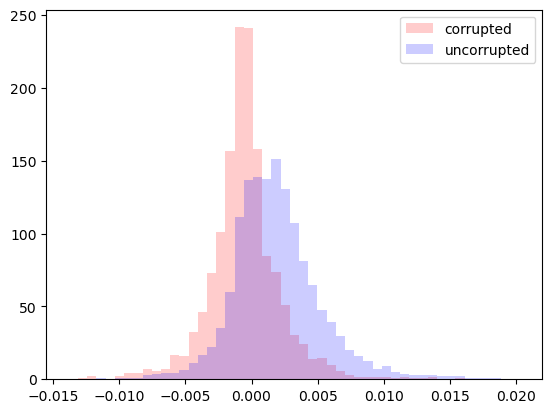

In [153]:
plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)
plt.hist(vals_dvgs[endog_noise == 1], color='r', alpha=0.2, bins=bins, label='corrupted', density=True)
plt.hist(vals_dvgs[endog_noise == 0], color='b', alpha=0.2, bins=bins, label='uncorrupted', density=True)
plt.legend()
plt.show()

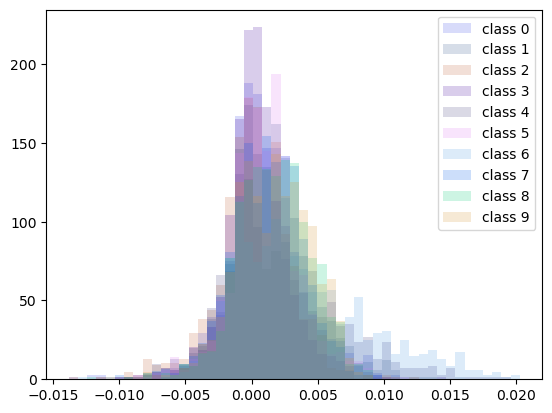

In [163]:
classes = list(np.sort(np.unique(y_train.detach().numpy()))) 


plt.figure() 
bins = np.linspace(vals_dvgs.min(), vals_dvgs.max(), 50)

for c in classes: 
    class_idx = (y_train == c).nonzero(as_tuple=True)[0]
    class_color = np.random.uniform(0,1,size=4)
    plt.hist(vals_dvgs[class_idx], color=class_color, alpha=0.2, bins=bins, label=f'class {c}', density=True)
plt.legend()
plt.show()

(10000,)


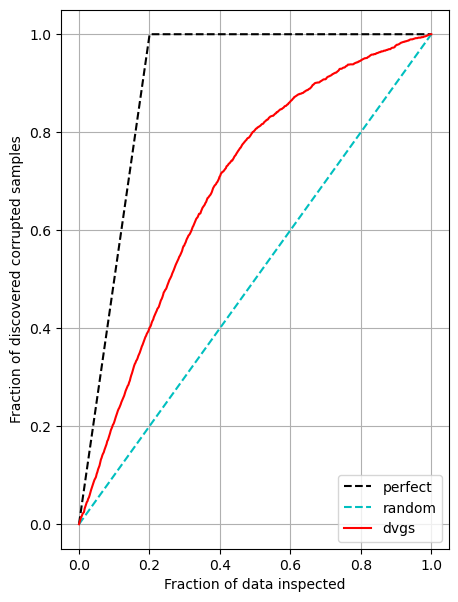

In [164]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, endog_noise.nonzero()[0], train_size=10000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [37]:
#model = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=False, dropout=0., bias=True, act=torch.nn.ReLU, out_fn=torch.nn.Softmax(dim=-1))
#model = LogisticRegression(108, 2)  
CEL = torch.nn.CrossEntropyLoss() 

dshap = DShap.DShap(model           = copy.deepcopy(model).cpu(), 
                    crit            = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)),
                    x_train         = torch.tensor(x_train, dtype=torch.float), 
                    y_train         = torch.tensor(y_train, dtype=torch.float).view(-1,1),
                    x_valid         = torch.tensor(x_valid, dtype=torch.float), 
                    y_valid         = torch.tensor(y_valid, dtype=torch.float).view(-1,1), 
                    perf_metric     = lambda y, yhat: roc_auc_score(y, yhat[:, 1]),
                    epochs          = 100,
                    tol             = 0.03,
                    optim           = torch.optim.Adam,
                    lr              = 1e-3,
                    verbose = True)

tic = time.time() 
vals_shap = dshap.TMC(max_iterations=500, min_iterations=100, use_cuda=True, T=5, stopping_criteria=0.999)

print()
print(f'time elapsed: {(time.time() - tic)/60:.2f} min')

v0 (null model): 0.4355
vD (all data): 0.8169

starting Data Shapley TMC...
iter: 99 || max j: 173 || max vj: 0.7938 || rank_corr: 0.9991
MC stopping criteria met. running avg rank correlation: 0.9992

time elapsed: 41.26 min


In [95]:
#model = LogisticRegression(108, 2)  
model = NN(in_channels=108, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.25, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long)) 
metric = lambda y,yhat: roc_auc_score(y, yhat[:, 1])  

loo = LOO(x_train       = torch.tensor(x_train, dtype=torch.float), 
          y_train       = torch.tensor(y_train, dtype=torch.float).view(-1,1),
          x_valid       = torch.tensor(x_valid, dtype=torch.float), 
          y_valid       = torch.tensor(y_valid, dtype=torch.float).view(-1,1),
          model         = copy.deepcopy(model),
          metric        = metric,
          crit          = crit, 
          optim         = torch.optim.Adam, 
          epochs        = 100, 
          lr            = 1e-4,
          batch_size    = 256, 
          use_cuda      = True, 
          verbose       = True, 
          baseline_repl = 10,
          n_repl        = 1)

print()  

loo_values = loo.run()

baseline performance: 0.822 +/- 0.001



In [96]:
vals_loo = np.array(loo_values)

(1000,)


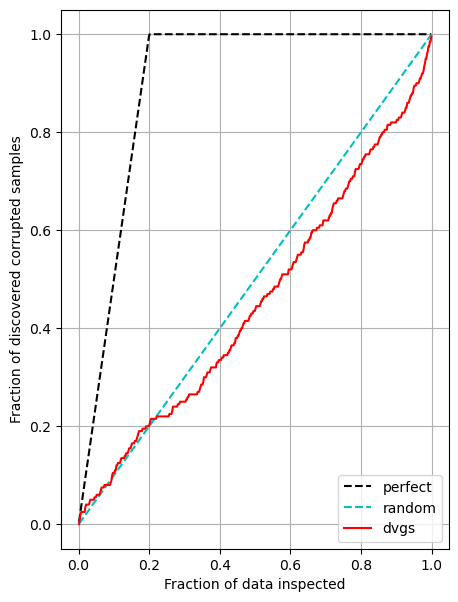

In [97]:
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_loo, noise_idx, train_size=1000, noise_prop=0.2)

plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [98]:
dvgs_data_values = vals_dvgs
#dvrl_data_values = vals_dvrl.detach().cpu().numpy().ravel() 
shap_data_values = vals_shap.ravel()

noise_idx = endog_noise.nonzero(as_tuple=True)[0]

#pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(dvrl_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, shap_corr, p_perfect, p_random = get_corruption_scores(shap_data_values, noise_idx, train_size=1000, noise_prop=0.2)
pk, dvgs_corr, p_perfect, p_random = get_corruption_scores(vals_dvgs, noise_idx, train_size=1000, noise_prop=0.2)
pk, loo_corr, p_perfect, p_random = get_corruption_scores(np.array(loo_values), noise_idx, train_size=1000, noise_prop=0.2)

NameError: name 'vals_shap' is not defined

NameError: name 'shap_corr' is not defined

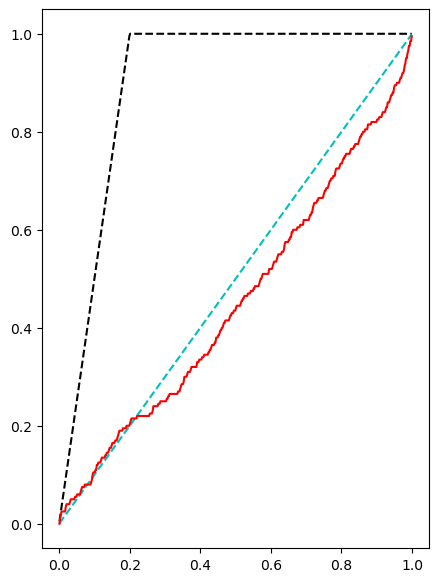

In [99]:
plt.figure(figsize=(5, 7))
plt.plot(pk, p_perfect, 'k--', label='perfect')
plt.plot(pk, p_random, 'c--', label='random')
plt.plot(pk, dvgs_corr, 'r-', label='dvgs')
#plt.plot(pk, dvrl_corr, 'g-', label='dvrl')
plt.plot(pk, shap_corr, 'b-', label='Dshap.')
plt.plot(pk, loo_corr, 'g-', label='LOO')
plt.legend()
plt.ylabel('Fraction of discovered corrupted samples')
plt.xlabel('Fraction of data inspected')
plt.grid(b=None)
plt.show()

In [181]:
#model = NN(in_channels=280, out_channels=2, num_layers=2, hidden_channels=100, norm=True, dropout=0.0, bias=True, act=torch.nn.Mish, out_fn=torch.nn.Softmax(dim=-1))
CEL = torch.nn.CrossEntropyLoss() 
crit = lambda x,y: CEL(x,y.squeeze(1).type(torch.long))
metric = lambda y,yhat: roc_auc_score(y, yhat, multi_class='ovr') 

rand_data_values = np.random.normal(0,1,size=dvgs_data_values.shape)

qs = np.linspace(0., 0.5, 10)
bs = 512 
lr = 1e-3 
ep = 200
rp = 3

dvgs_low, dvgs_high = get_filtered_scores(dvgs_data_values, model, crit, metric, x_train, y_train, x_test, y_test, qs=qs, batch_size=bs, lr=lr, epochs=ep, repl=rp)
#dvrl_low, dvrl_high = get_filtered_scores(dvrl_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, lr=lr, epochs=ep, repl=rp)
#shap_low, shap_high = get_filtered_scores(shap_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, lr=lr, epochs=ep, repl=rp)
#rand_low, rand_high = get_filtered_scores(rand_data_values, model, crit, metric, x_train, y_train.reshape(-1, 1), x_test, y_test.reshape(-1,1), qs=qs, batch_size=bs, lr=lr, epochs=ep, repl=rp)


training filtered models... progress: 9/10


In [184]:
dvgs_low

[0.7085290796296296,
 0.7056988814814815,
 0.7046249944444444,
 0.7088086851851852,
 0.7058819537037037,
 0.7074713796296296,
 0.7020336333333334,
 0.7048543592592592,
 0.7143247870370372,
 0.6853908796296295]

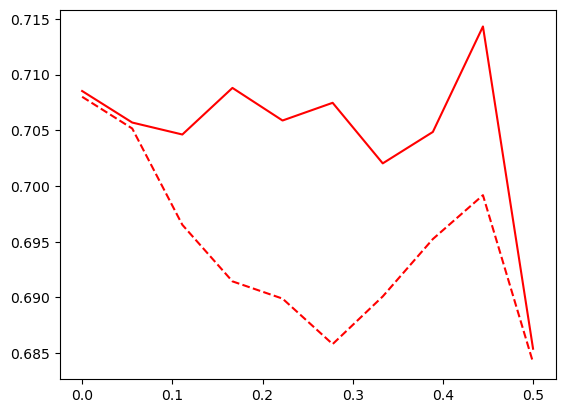

In [182]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

NameError: name 'dvrl_low' is not defined

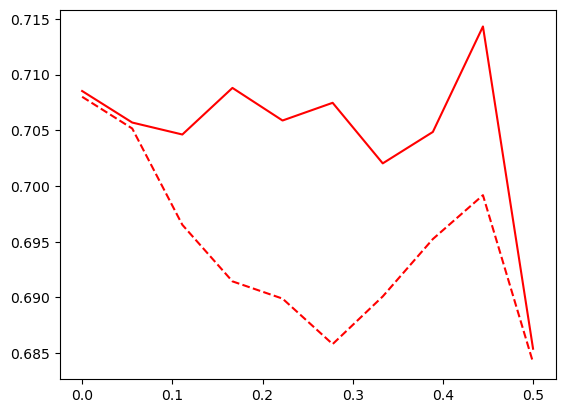

In [183]:
plt.figure()
plt.plot(qs, dvgs_low, 'r-', label='dvgs-low')
plt.plot(qs, dvgs_high, 'r--', label='dvgs-high')

plt.plot(qs, dvrl_low, 'g-', label='dvrl-low')
plt.plot(qs, dvrl_high, 'g--', label='dvrl-high')

plt.plot(qs, shap_low, 'b-', label='shap-low')
plt.plot(qs, shap_high, 'b--', label='shap-high')

plt.plot(qs, rand_low, 'c-', label='rand-low')
plt.plot(qs, rand_high, 'c--', label='rand-high')

plt.xlabel('Fraction data filtered')
plt.ylabel('Model Performance (AUROC)')
plt.legend() 
plt.show()